In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

!pip install optuna
!pip install timm
!pip install scikit-learn
!pip install pandas
!pip install seaborn

torch version: 1.13.1
torchvision version: 0.14.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 8.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 68.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.7/613.7 kB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 12.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 38.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 40.0 MB/s eta 0:00:0000:0100:01
  Using cached threa

In [2]:
# Continue with regular imports
!pip install matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
!pip install ipython-autotime
%load_ext autotime

[INFO] Couldn't find torchinfo... installing it.
time: 481 µs (started: 2023-04-30 08:04:01 +00:00)


In [ ]:
#unzip the data that we had split earlier before in the preprocessing notebook, to ensure that the same arrangement of data 
#is used for every model. 
!unzip /isic2019-dataset.zip

In [9]:
from torchvision.transforms import Compose, CenterCrop, Normalize, Resize, ToTensor
from torchvision.transforms import InterpolationMode
from torchvision.transforms import RandAugment

# Set the random seed for reproducibility
torch.manual_seed(42)

# Define the transformation parameters
resize_size = [224, 224]
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
interpolation = InterpolationMode.BICUBIC

# Define the randaugment transformation pipeline for the training set
randaug_transform = Compose([
    RandAugment(num_ops=3, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None),
    Resize(resize_size, interpolation=interpolation),
    ToTensor(),
    Normalize(mean=mean, std=std)
])

# Get a set of pretrained model weights
weights = torchvision.models.MaxVit_T_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

# define the transform function that will be used in imagefolder to preprocess the data for validation and test data
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[224]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

time: 4.1 ms (started: 2023-04-30 08:18:19 +00:00)


In [10]:
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import optuna
import timm
import torch.utils.data.sampler as sampler
from torch.utils.data import Subset
from torch.utils.data.sampler import RandomSampler
import torchvision.datasets as datasets

# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

#define hyperparameter tuning, furthermore we will use 
#10 trials to look for the best hyperparameters. We re-used the optuna hyperparameter
#optimization code 

# Define the dataset and dataloader
def get_data_loaders(batch_size):

# Load and transform the data

    # Load the datasets
    train_dataset = datasets.ImageFolder(root='data/train', transform=randaug_transform)
    val_dataset = datasets.ImageFolder(root='data/valid', transform=auto_transforms)

    # load the data and shuffle the training data
    train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    return train_dataloader, valid_dataloader

def get_model(trial, dropout, num_hidden_layers, num_neurons):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_name = 'maxvit_rmlp_small_rw_224'
    model = timm.create_model(model_name, pretrained=True, num_classes=8)

    num_in_features = model.get_classifier().in_features

    # Define the classification head
    classifier_layers = []
    for i in range(num_hidden_layers):
        if i == 0:
            in_features = num_in_features
            out_features = num_neurons
        else:
            in_features = num_neurons
            out_features = num_neurons
        classifier_layers.extend([
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Dropout(p=dropout),
        ])
    classifier_layers.append(nn.Linear(num_neurons, 8))
    model.head.fc = nn.Sequential(*classifier_layers)

    # Freeze the weights
    for param in model.parameters():
        param.requires_grad = False
   
    # Unfreeze the classifierhead layer 
    for param in model.head.parameters():
        param.requires_grad = True

    return model

# Define the objective function for Optuna
def objective(trial):
    # Get the hyperparameters to optimize
    batch_size = 32  # set batch size to 32
    epochs = 20  # set epochs to 20
    optimizer_name = trial.suggest_categorical("optimizer_name", ["AdamW", "SGD"])
    weight_decay = trial.suggest_float("weight_decay", low=0.001, high=0.01, log=True)
    learning_rate = trial.suggest_float("learning_rate", low=0.001, high=0.01, log=True)
    dropout = trial.suggest_categorical("dropout", [0.25,0.5])
    num_hidden_layers = trial.suggest_int("num_hidden_layers", low=1, high=2)
    num_neurons = trial.suggest_categorical("num_neurons", [256, 512])

    # Get the data loaders
    train_dataloader, valid_dataloader = get_data_loaders(batch_size)

    # Get the model
    model = get_model(trial, dropout, num_hidden_layers, num_neurons)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Define the optimizer and loss function
    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

# Initialize variables for early stopping
    best_accuracy = 0.0
    best_val_loss = float('inf')
    patience = 5
    no_improvement_count = 0

   # Train the model
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        running_total = 0
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                scaler.scale(loss).backward()    # Scale the gradients
                scaler.step(optimizer)           # Update the model parameters
                scaler.update()                  # Update the scaler

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_corrects += (predicted == labels).sum().item()

        # Calculate the training loss and training accuracy
        train_loss = running_loss / len(train_dataloader)
        train_accuracy = 100 * running_corrects / running_total

        # evaluate on the validation set
        correct = 0
        total = 0
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for data in valid_dataloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

        # Calculate the validation accuracy and validation loss
        accuracy = 100 * correct / total
        val_loss /= len(valid_dataloader)


        # Print the accuracy and validation loss
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Validation Loss = {val_loss:.4f}, Validation Accuracy = {accuracy:.2f}%")

        # Report the intermediate result
        trial.report(accuracy, epoch)

        # Check if the validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Check if the accuracy has improved
        if accuracy > best_accuracy:
            best_accuracy = accuracy

        # Check if early stopping criteria has been met
        if no_improvement_count >= patience:
            print(f"No improvement after {no_improvement_count} epochs. Stopping training...")
            break

    return best_accuracy

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-04-30 08:18:19,883] A new study created in memory with name: no-name-dbc0715d-ca94-4709-bc1f-b45c9dd15fc5


Epoch 1: Train Loss = 1.1721, Train Accuracy = 60.18%, Validation Loss = 0.9756, Validation Accuracy = 65.12%
Epoch 2: Train Loss = 0.9757, Train Accuracy = 65.34%, Validation Loss = 0.9036, Validation Accuracy = 67.83%
Epoch 3: Train Loss = 0.9462, Train Accuracy = 66.20%, Validation Loss = 0.9075, Validation Accuracy = 67.56%
Epoch 4: Train Loss = 0.9301, Train Accuracy = 66.93%, Validation Loss = 0.8763, Validation Accuracy = 68.34%
Epoch 5: Train Loss = 0.9190, Train Accuracy = 66.99%, Validation Loss = 0.8751, Validation Accuracy = 67.32%
Epoch 6: Train Loss = 0.9046, Train Accuracy = 67.33%, Validation Loss = 0.8465, Validation Accuracy = 69.64%
Epoch 7: Train Loss = 0.8998, Train Accuracy = 67.67%, Validation Loss = 0.8554, Validation Accuracy = 69.17%
Epoch 8: Train Loss = 0.8913, Train Accuracy = 67.76%, Validation Loss = 0.8674, Validation Accuracy = 68.58%
Epoch 9: Train Loss = 0.8801, Train Accuracy = 68.07%, Validation Loss = 0.8318, Validation Accuracy = 70.31%
Epoch 10: 

[I 2023-04-30 08:58:03,527] Trial 0 finished with value: 70.30636292223095 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.005692631149847043, 'learning_rate': 0.0029045988874773386, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 512}. Best is trial 0 with value: 70.30636292223095.


Epoch 14: Train Loss = 0.8586, Train Accuracy = 69.32%, Validation Loss = 0.8363, Validation Accuracy = 69.76%
No improvement after 5 epochs. Stopping training...
Epoch 1: Train Loss = 1.1650, Train Accuracy = 60.74%, Validation Loss = 0.9283, Validation Accuracy = 66.58%
Epoch 2: Train Loss = 0.9583, Train Accuracy = 65.60%, Validation Loss = 0.8806, Validation Accuracy = 68.11%
Epoch 3: Train Loss = 0.9247, Train Accuracy = 67.08%, Validation Loss = 0.8745, Validation Accuracy = 68.97%
Epoch 4: Train Loss = 0.9100, Train Accuracy = 67.62%, Validation Loss = 0.8795, Validation Accuracy = 67.75%
Epoch 5: Train Loss = 0.9024, Train Accuracy = 67.17%, Validation Loss = 0.8722, Validation Accuracy = 68.26%
Epoch 6: Train Loss = 0.8948, Train Accuracy = 67.98%, Validation Loss = 0.8325, Validation Accuracy = 70.07%
Epoch 7: Train Loss = 0.8834, Train Accuracy = 68.24%, Validation Loss = 0.8401, Validation Accuracy = 69.64%
Epoch 8: Train Loss = 0.8791, Train Accuracy = 68.34%, Validation L

[I 2023-04-30 09:55:53,336] Trial 1 finished with value: 71.48468185388845 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.009180866149599651, 'learning_rate': 0.0010922617771103266, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 1 with value: 71.48468185388845.


Epoch 20: Train Loss = 0.8398, Train Accuracy = 69.32%, Validation Loss = 0.8041, Validation Accuracy = 70.93%
Epoch 1: Train Loss = 1.2160, Train Accuracy = 59.53%, Validation Loss = 0.9782, Validation Accuracy = 64.41%
Epoch 2: Train Loss = 0.9725, Train Accuracy = 65.57%, Validation Loss = 0.9130, Validation Accuracy = 67.32%
Epoch 3: Train Loss = 0.9340, Train Accuracy = 66.34%, Validation Loss = 0.9031, Validation Accuracy = 67.83%
Epoch 4: Train Loss = 0.9224, Train Accuracy = 67.07%, Validation Loss = 0.8952, Validation Accuracy = 67.56%
Epoch 5: Train Loss = 0.9211, Train Accuracy = 67.02%, Validation Loss = 0.8948, Validation Accuracy = 68.15%
Epoch 6: Train Loss = 0.9042, Train Accuracy = 67.63%, Validation Loss = 0.8952, Validation Accuracy = 68.85%
Epoch 7: Train Loss = 0.8982, Train Accuracy = 67.89%, Validation Loss = 0.8522, Validation Accuracy = 69.36%
Epoch 8: Train Loss = 0.8874, Train Accuracy = 67.82%, Validation Loss = 0.8749, Validation Accuracy = 67.83%
Epoch 9: 

[I 2023-04-30 10:52:36,509] Trial 2 finished with value: 71.09190887666928 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.009031303803664952, 'learning_rate': 0.0014756532682805887, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 512}. Best is trial 1 with value: 71.48468185388845.


Epoch 20: Train Loss = 0.8354, Train Accuracy = 69.66%, Validation Loss = 0.8134, Validation Accuracy = 70.90%
Epoch 1: Train Loss = 1.1485, Train Accuracy = 61.28%, Validation Loss = 0.9288, Validation Accuracy = 67.36%
Epoch 2: Train Loss = 0.9619, Train Accuracy = 65.96%, Validation Loss = 0.8747, Validation Accuracy = 68.22%
Epoch 3: Train Loss = 0.9252, Train Accuracy = 66.81%, Validation Loss = 0.9007, Validation Accuracy = 66.77%
Epoch 4: Train Loss = 0.9141, Train Accuracy = 67.47%, Validation Loss = 0.9323, Validation Accuracy = 66.38%
Epoch 5: Train Loss = 0.9012, Train Accuracy = 67.37%, Validation Loss = 0.8554, Validation Accuracy = 69.48%
Epoch 6: Train Loss = 0.8913, Train Accuracy = 67.89%, Validation Loss = 0.8337, Validation Accuracy = 69.60%
Epoch 7: Train Loss = 0.8872, Train Accuracy = 67.90%, Validation Loss = 0.8267, Validation Accuracy = 70.27%
Epoch 8: Train Loss = 0.8806, Train Accuracy = 68.30%, Validation Loss = 0.8471, Validation Accuracy = 69.48%
Epoch 9: 

[I 2023-04-30 11:50:23,074] Trial 3 finished with value: 71.44540455616654 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0024113140654875493, 'learning_rate': 0.0012404518292552984, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 1 with value: 71.48468185388845.


Epoch 20: Train Loss = 0.8327, Train Accuracy = 69.58%, Validation Loss = 0.8077, Validation Accuracy = 70.50%
Epoch 1: Train Loss = 1.1893, Train Accuracy = 59.87%, Validation Loss = 1.0234, Validation Accuracy = 63.94%
Epoch 2: Train Loss = 0.9791, Train Accuracy = 65.52%, Validation Loss = 0.9181, Validation Accuracy = 67.28%
Epoch 3: Train Loss = 0.9473, Train Accuracy = 66.13%, Validation Loss = 0.8698, Validation Accuracy = 69.21%
Epoch 4: Train Loss = 0.9323, Train Accuracy = 66.59%, Validation Loss = 0.8769, Validation Accuracy = 68.19%
Epoch 5: Train Loss = 0.9257, Train Accuracy = 66.81%, Validation Loss = 0.8705, Validation Accuracy = 67.87%
Epoch 6: Train Loss = 0.9191, Train Accuracy = 67.03%, Validation Loss = 0.8539, Validation Accuracy = 69.68%
Epoch 7: Train Loss = 0.9085, Train Accuracy = 67.29%, Validation Loss = 0.8598, Validation Accuracy = 68.62%
Epoch 8: Train Loss = 0.8962, Train Accuracy = 67.99%, Validation Loss = 0.8624, Validation Accuracy = 67.83%
Epoch 9: 

[I 2023-04-30 12:47:09,177] Trial 4 finished with value: 70.81696779261587 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.006603501124571264, 'learning_rate': 0.005949148744939243, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 512}. Best is trial 1 with value: 71.48468185388845.


Epoch 20: Train Loss = 0.8553, Train Accuracy = 69.09%, Validation Loss = 0.8202, Validation Accuracy = 70.82%
Epoch 1: Train Loss = 1.2311, Train Accuracy = 59.66%, Validation Loss = 0.9859, Validation Accuracy = 65.48%
Epoch 2: Train Loss = 0.9507, Train Accuracy = 66.64%, Validation Loss = 0.8792, Validation Accuracy = 67.91%
Epoch 3: Train Loss = 0.9176, Train Accuracy = 66.90%, Validation Loss = 0.8686, Validation Accuracy = 68.70%
Epoch 4: Train Loss = 0.8954, Train Accuracy = 67.49%, Validation Loss = 0.8558, Validation Accuracy = 67.52%
Epoch 5: Train Loss = 0.8858, Train Accuracy = 68.22%, Validation Loss = 0.8583, Validation Accuracy = 68.50%
Epoch 6: Train Loss = 0.8809, Train Accuracy = 67.81%, Validation Loss = 0.8321, Validation Accuracy = 69.64%
Epoch 7: Train Loss = 0.8744, Train Accuracy = 68.25%, Validation Loss = 0.8280, Validation Accuracy = 70.42%
Epoch 8: Train Loss = 0.8641, Train Accuracy = 68.85%, Validation Loss = 0.8267, Validation Accuracy = 69.56%
Epoch 9: 

[I 2023-04-30 13:44:08,529] Trial 5 finished with value: 70.77769049489395 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0035244437351727885, 'learning_rate': 0.0033791234614556857, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 1 with value: 71.48468185388845.


Epoch 20: Train Loss = 0.8457, Train Accuracy = 69.42%, Validation Loss = 0.8222, Validation Accuracy = 69.91%
No improvement after 5 epochs. Stopping training...
Epoch 1: Train Loss = 1.3185, Train Accuracy = 57.64%, Validation Loss = 0.9997, Validation Accuracy = 65.55%
Epoch 2: Train Loss = 0.9598, Train Accuracy = 66.30%, Validation Loss = 0.9035, Validation Accuracy = 67.24%
Epoch 3: Train Loss = 0.9195, Train Accuracy = 67.15%, Validation Loss = 0.8788, Validation Accuracy = 68.58%
Epoch 4: Train Loss = 0.9053, Train Accuracy = 67.44%, Validation Loss = 0.8540, Validation Accuracy = 69.56%
Epoch 5: Train Loss = 0.8893, Train Accuracy = 67.80%, Validation Loss = 0.8449, Validation Accuracy = 70.15%
Epoch 6: Train Loss = 0.8810, Train Accuracy = 68.29%, Validation Loss = 0.8477, Validation Accuracy = 69.60%
Epoch 7: Train Loss = 0.8754, Train Accuracy = 68.50%, Validation Loss = 0.8513, Validation Accuracy = 69.48%
Epoch 8: Train Loss = 0.8743, Train Accuracy = 68.43%, Validation L

[I 2023-04-30 14:32:34,454] Trial 6 finished with value: 70.54202670856245 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0053827721626703955, 'learning_rate': 0.0019169931592842235, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 1 with value: 71.48468185388845.


Epoch 17: Train Loss = 0.8650, Train Accuracy = 69.10%, Validation Loss = 0.8413, Validation Accuracy = 69.68%
No improvement after 5 epochs. Stopping training...
Epoch 1: Train Loss = 1.1403, Train Accuracy = 60.64%, Validation Loss = 0.9133, Validation Accuracy = 67.40%
Epoch 2: Train Loss = 0.9717, Train Accuracy = 65.63%, Validation Loss = 0.9220, Validation Accuracy = 66.73%
Epoch 3: Train Loss = 0.9465, Train Accuracy = 65.96%, Validation Loss = 0.9128, Validation Accuracy = 67.64%
Epoch 4: Train Loss = 0.9401, Train Accuracy = 66.47%, Validation Loss = 0.8798, Validation Accuracy = 68.38%
Epoch 5: Train Loss = 0.9280, Train Accuracy = 66.81%, Validation Loss = 0.8893, Validation Accuracy = 68.38%
Epoch 6: Train Loss = 0.9171, Train Accuracy = 67.22%, Validation Loss = 0.8725, Validation Accuracy = 69.32%
Epoch 7: Train Loss = 0.9110, Train Accuracy = 67.41%, Validation Loss = 0.8766, Validation Accuracy = 68.46%
Epoch 8: Train Loss = 0.9028, Train Accuracy = 67.58%, Validation L

[I 2023-04-30 15:30:23,453] Trial 7 finished with value: 70.81696779261587 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.002157754523373943, 'learning_rate': 0.00975648882616168, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 1 with value: 71.48468185388845.


Epoch 20: Train Loss = 0.8665, Train Accuracy = 69.17%, Validation Loss = 0.8470, Validation Accuracy = 68.46%
Epoch 1: Train Loss = 1.1193, Train Accuracy = 61.79%, Validation Loss = 0.9215, Validation Accuracy = 66.81%
Epoch 2: Train Loss = 0.9534, Train Accuracy = 65.71%, Validation Loss = 0.8793, Validation Accuracy = 67.48%
Epoch 3: Train Loss = 0.9262, Train Accuracy = 66.73%, Validation Loss = 0.8603, Validation Accuracy = 68.26%
Epoch 4: Train Loss = 0.9032, Train Accuracy = 67.46%, Validation Loss = 0.8402, Validation Accuracy = 69.64%
Epoch 5: Train Loss = 0.8814, Train Accuracy = 68.09%, Validation Loss = 0.8459, Validation Accuracy = 69.05%
Epoch 6: Train Loss = 0.8815, Train Accuracy = 68.24%, Validation Loss = 0.8372, Validation Accuracy = 69.84%
Epoch 7: Train Loss = 0.8783, Train Accuracy = 68.53%, Validation Loss = 0.8480, Validation Accuracy = 68.85%
Epoch 8: Train Loss = 0.8729, Train Accuracy = 68.42%, Validation Loss = 0.8195, Validation Accuracy = 69.64%
Epoch 9: 

[I 2023-04-30 16:27:26,543] Trial 8 finished with value: 71.3668499607227 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0026339205530110468, 'learning_rate': 0.0023693530395286298, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 1 with value: 71.48468185388845.


Epoch 20: Train Loss = 0.8380, Train Accuracy = 69.58%, Validation Loss = 0.7944, Validation Accuracy = 71.37%
Epoch 1: Train Loss = 1.1254, Train Accuracy = 61.48%, Validation Loss = 0.9383, Validation Accuracy = 65.87%
Epoch 2: Train Loss = 0.9521, Train Accuracy = 65.75%, Validation Loss = 0.8871, Validation Accuracy = 67.05%
Epoch 3: Train Loss = 0.9204, Train Accuracy = 66.66%, Validation Loss = 0.8820, Validation Accuracy = 68.30%
Epoch 4: Train Loss = 0.9014, Train Accuracy = 67.41%, Validation Loss = 0.8618, Validation Accuracy = 68.38%
Epoch 5: Train Loss = 0.8923, Train Accuracy = 67.89%, Validation Loss = 0.8502, Validation Accuracy = 69.48%
Epoch 6: Train Loss = 0.8774, Train Accuracy = 68.54%, Validation Loss = 0.8595, Validation Accuracy = 69.25%
Epoch 7: Train Loss = 0.8807, Train Accuracy = 67.90%, Validation Loss = 0.8493, Validation Accuracy = 69.25%
Epoch 8: Train Loss = 0.8654, Train Accuracy = 69.12%, Validation Loss = 0.8358, Validation Accuracy = 70.58%
Epoch 9: 

[I 2023-04-30 17:20:22,338] Trial 9 finished with value: 71.40612725844461 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.004396990459702675, 'learning_rate': 0.0018895714091217296, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 1 with value: 71.48468185388845.


Epoch 20: Train Loss = 0.8329, Train Accuracy = 69.85%, Validation Loss = 0.8150, Validation Accuracy = 70.90%
No improvement after 5 epochs. Stopping training...
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  0
  Number of complete trials:  10
Best trial:
  Value:  71.48468185388845
  Params: 
    optimizer_name: AdamW
    weight_decay: 0.009180866149599651
    learning_rate: 0.0010922617771103266
    dropout: 0.25
    num_hidden_layers: 2
    num_neurons: 256
time: 9h 2min 2s (started: 2023-04-30 08:18:19 +00:00)


/tmp/ipykernel_390/2794341735.py:3: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

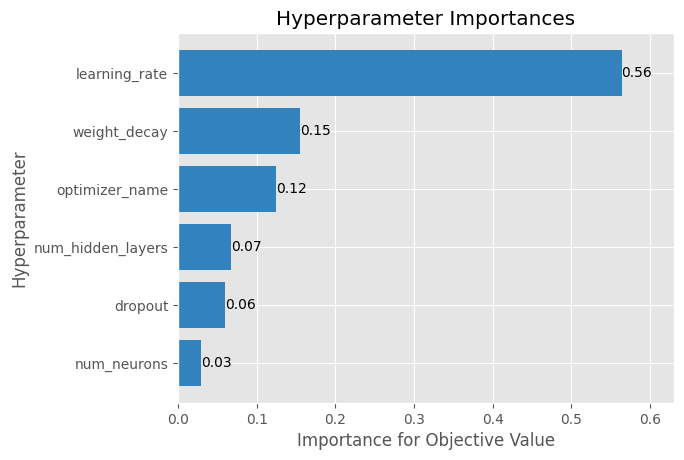

time: 288 ms (started: 2023-04-30 17:22:33 +00:00)


In [16]:
#shows the importance of each hyperparameter

fig = optuna.visualization.matplotlib.plot_param_importances(study)
fig

In [40]:
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import Subset

# Set the random seed for reproducibility
torch.manual_seed(42)

# Load and transform the data
train_dataset = datasets.ImageFolder(root='data/train', transform=randaug_transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=auto_transforms)
val_dataset = datasets.ImageFolder(root='data/valid', transform=auto_transforms)

# load the data and shuffle the training data
train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True, num_workers=5)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True,num_workers=5)
valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True,num_workers=5)

time: 48.4 ms (started: 2023-04-30 17:51:18 +00:00)


In [41]:
import timm 
#look up all the maxvit models in timm's library
maxvit_models = timm.list_models('*maxvit*')
maxvit_models

['maxvit_base_224',
 'maxvit_large_224',
 'maxvit_nano_rw_256',
 'maxvit_pico_rw_256',
 'maxvit_rmlp_nano_rw_256',
 'maxvit_rmlp_pico_rw_256',
 'maxvit_rmlp_small_rw_224',
 'maxvit_rmlp_small_rw_256',
 'maxvit_rmlp_tiny_rw_256',
 'maxvit_small_224',
 'maxvit_tiny_224',
 'maxvit_tiny_pm_256',
 'maxvit_tiny_rw_224',
 'maxvit_tiny_rw_256',
 'maxvit_xlarge_224']

time: 4.28 ms (started: 2023-04-30 17:51:24 +00:00)


In [42]:
# Retrieve the best set of hyperparameters
best_params = study.best_params
print(best_params)

{'optimizer_name': 'AdamW', 'weight_decay': 0.009180866149599651, 'learning_rate': 0.0010922617771103266, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}
time: 985 µs (started: 2023-04-30 17:51:28 +00:00)


In [43]:
#create the maxvit model
#to create this code, timm's library has been used. 
#create model with new variable name and the best HP values to re-train the model 

import timm 
import torch
import torch.nn as nn

# Set the random seed for reproducibility
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
new_model = timm.create_model('maxvit_rmlp_small_rw_224', pretrained=True, num_classes=8)

num_in_features = new_model.get_classifier().in_features

# Define the classification head
num_hidden_layers = 2
num_neurons = 256
dropout = 0.25
best_params = study.best_params
print(best_params)
classifier_layers = []
for i in range(num_hidden_layers):
    if i == 0:
        in_features = num_in_features
        out_features = num_neurons
    else:
        in_features = num_neurons
        out_features = num_neurons
    classifier_layers.extend([
        nn.Linear(in_features, out_features),
        nn.BatchNorm1d(out_features),
        nn.Dropout(p=dropout),
    ])
classifier_layers.append(nn.Linear(num_neurons, 8))
new_model.head.fc = nn.Sequential(*classifier_layers)

#freeze the weights
for param in new_model.parameters():
    param.requires_grad = False
   
# unfreeze the last fc layer
for param in new_model.head.parameters():
    param.requires_grad = True


new_model.to(device)

{'optimizer_name': 'AdamW', 'weight_decay': 0.009180866149599651, 'learning_rate': 0.0010922617771103266, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}


MaxxVit(
  (stem): Stem(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (stages): Sequential(
    (0): MaxxVitStage(
      (blocks): Sequential(
        (0): MaxxVitBlock(
          (conv): MbConvBlock(
            (shortcut): Downsample2d(
              (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
              (expand): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
            (pre_norm): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Identity()
            )
            (down): Identity()
            (conv1_1x1): Conv2d(64, 256, kernel_size=(1

time: 1.04 s (started: 2023-04-30 17:51:29 +00:00)


In [44]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=new_model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MaxxVit (MaxxVit)                                                 [32, 3, 224, 224]    [32, 8]              --                   Partial
├─Stem (stem)                                                     [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    └─Conv2d (conv1)                                             [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNormAct2d (norm1)                                     [32, 32, 112, 112]   [32, 32, 112, 112]   64                   False
│    │    └─Identity (drop)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    │    └─SiLU (act)                                            [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Conv2d (conv2)                                  

time: 193 ms (started: 2023-04-30 17:51:30 +00:00)


In [45]:
# define optimizers and loss function and use the best hyperparameters found during the HP tuning

# Set the random seed for reproducibility
torch.manual_seed(42)

# Setup device agnostic code
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(new_model.parameters(), lr=0.0010922617771103266, weight_decay = 0.009180866149599651)

time: 6.42 ms (started: 2023-04-30 17:51:31 +00:00)


In [46]:
#in this code we apply mixed precision training to allow for faster training and use early stopping to prevent overfitting 

# Set the random seed for reproducibility
torch.manual_seed(42)

import matplotlib.pyplot as plt
import torch
# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

# Lists to store the loss and accuracy values
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Train the model
num_epochs = 20
best_val_loss = float('inf')
patience = 5
for epoch in range(num_epochs):
    # Train the model
    new_model.train()
    train_loss = 0.0
    train_acc = 0.0
    for data in train_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()    # Scale the gradients
        scaler.step(optimizer)           # Update the model parameters
        scaler.update()                  # Update the scaler
        train_loss += loss.item() * inputs.size(0)
        train_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    # Evaluate the model
    new_model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for data in valid_dataloader:
            inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    # Print the results for this epoch
    train_loss /= len(train_dataloader.dataset)
    train_acc /= len(train_dataloader.dataset)
    val_loss /= len(valid_dataloader.dataset)
    val_acc /= len(valid_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save the loss and accuracy values
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Check if the current validation loss is the best seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = new_model.state_dict()
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    # Stop training if the validation loss has not improved for `patience` epochs
    if epochs_since_improvement == patience:
        print(f"No improvement for {patience} epochs, stopping training.")
        break

Epoch 1/20: Train Loss: 1.1604, Train Acc: 0.6110, Val Loss: 0.9777, Val Acc: 0.6571
Epoch 2/20: Train Loss: 0.9947, Train Acc: 0.6474, Val Loss: 0.8985, Val Acc: 0.6760
Epoch 3/20: Train Loss: 0.9716, Train Acc: 0.6539, Val Loss: 0.8768, Val Acc: 0.6885
Epoch 4/20: Train Loss: 0.9516, Train Acc: 0.6619, Val Loss: 0.8525, Val Acc: 0.6936
Epoch 5/20: Train Loss: 0.9392, Train Acc: 0.6636, Val Loss: 0.8321, Val Acc: 0.6980
Epoch 6/20: Train Loss: 0.9330, Train Acc: 0.6640, Val Loss: 0.8446, Val Acc: 0.6964
Epoch 7/20: Train Loss: 0.9249, Train Acc: 0.6716, Val Loss: 0.8409, Val Acc: 0.6972
Epoch 8/20: Train Loss: 0.9121, Train Acc: 0.6732, Val Loss: 0.8512, Val Acc: 0.6870
Epoch 9/20: Train Loss: 0.9049, Train Acc: 0.6749, Val Loss: 0.8330, Val Acc: 0.6929
Epoch 10/20: Train Loss: 0.9028, Train Acc: 0.6759, Val Loss: 0.8220, Val Acc: 0.6984
Epoch 11/20: Train Loss: 0.8970, Train Acc: 0.6736, Val Loss: 0.8283, Val Acc: 0.6991
Epoch 12/20: Train Loss: 0.8975, Train Acc: 0.6771, Val Loss: 0

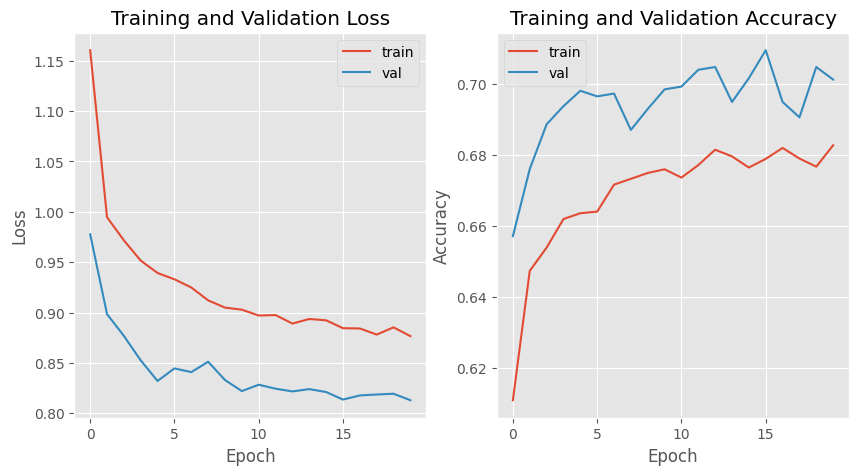

time: 245 ms (started: 2023-04-30 18:42:08 +00:00)


In [47]:
# Plot the validation and training loss and accuracy values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(val_losses, label='val')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(val_accs, label='val')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()
plt.show()

In [53]:
#evaluate on test set and calculate metrics

from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
import pandas as pd
import numpy as np

new_model.eval()
test_loss = 0.0
test_acc = 0.0
y_true = []
y_scores = []
y_pred = []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
        outputs = new_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        test_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

        # Append predictions to lists
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

test_loss /= len(test_dataloader.dataset)
test_acc /= len(test_dataloader.dataset)

# Calculate metrics

import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(8)], digits=4)

conf_mat = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(np.array(pd.get_dummies(y_true)), y_scores, average='macro')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate other metrices
n_classes = conf_mat.shape[0]
sensitivity = 0
specificity = 0
for i in range(n_classes):
    tp = conf_mat[i,i]
    fn = np.sum(conf_mat[i,:]) - tp
    fp = np.sum(conf_mat[:,i]) - tp
    tn = np.sum(conf_mat) - tp - fn - fp
    sensitivity += tp / (tp + fn) * np.sum(conf_mat[i,:])
    specificity += tn / (tn + fp) * np.sum(conf_mat[i,:])
sensitivity /= np.sum(conf_mat)
specificity /= np.sum(conf_mat)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Loss: 0.8514
Test Accuracy: 0.6907
Sensitivity: 0.6907
Specificity: 0.7977
ROC-AUC: 0.8892
F1-score: 0.6594
Classification Report:
              precision    recall  f1-score   support

           0     0.4000    0.2697    0.3221        89
           1     0.6080    0.6881    0.6456       311
           2     0.5497    0.3007    0.3888       276
           3     0.4000    0.0741    0.1250        27
           4     0.6457    0.4333    0.5186       450
           5     0.7396    0.9348    0.8258      1349
           6     0.7059    0.1463    0.2424        82
           7     0.6429    0.4091    0.5000        22

    accuracy                         0.6907      2606
   macro avg     0.5865    0.4070    0.4460      2606
weighted avg     0.6706    0.6907    0.6594      2606

time: 9.78 s (started: 2023-04-30 18:57:56 +00:00)


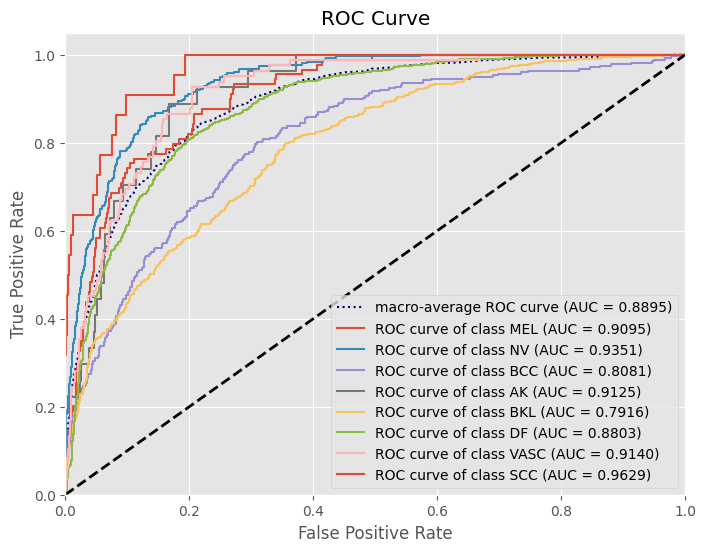

time: 170 ms (started: 2023-04-30 18:58:09 +00:00)


In [54]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Convert the y_true and y_scores lists to arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_true))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (AUC = {0:0.4f})'.format(roc_auc["macro"]), color='navy', linestyle=':')

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.4f})'.format(class_dict[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

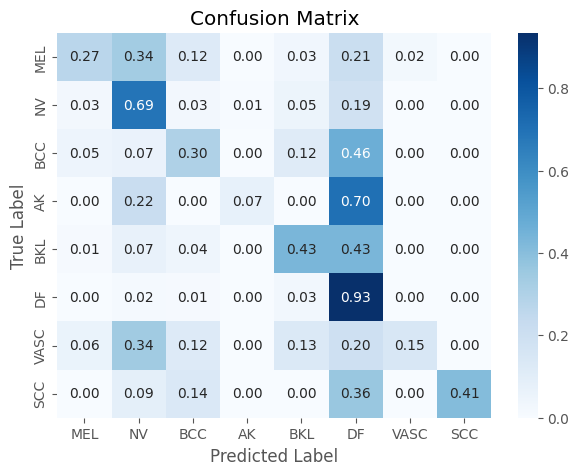

time: 232 ms (started: 2023-04-30 18:58:09 +00:00)


In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
class_labels = sorted(list(class_dict.keys()), key=lambda x: int(x))
ax.xaxis.set_ticklabels([class_dict[label] for label in class_labels])
ax.yaxis.set_ticklabels([class_dict[label] for label in class_labels])
plt.show()

